In [1]:
import numpy as np
import matplotlib.pyplot as plt

k_B = 1 # we use units of J/kT

class IsingModel2D:

    def __init__(self, lattice_length, J=1, H=0, **kwargs):
        """
        Initialize the Ising model with a given lattice size, interaction strength J, and external field H.

        Parameters:
        lattice_length (int): The size of the lattice (LxL).
        J (float, optional): The coupling constant in eV (default is 1).
        H (float, optional): The external magnetic field in T (default is 0).
        **kwargs (dict): kwargs to pass to initialize_lattice
        """
        self.lattice_length = lattice_length
        self.J = J
        self.H = H
        self.initialize_lattice(**kwargs)


    @property
    def lattice(self):
        """
        Return the lattice configuration.

        Returns:
        np.ndarray: The current state of the lattice (2D array of spins).
        """
        return self._lattice


    @property
    def average_energy(self):
        return self.get_average_energy()
    
    @property
    def average_magnetization(self):
        return self.get_average_magnetization()

    @property
    def total_magnetization(self):
        return self.get_total_magnetization()


    def flip_site(self, i, j):
        """
        Flip the spin at site (i, j).
        """
        self._lattice[i, j] *= -1


    def get_average_energy(self):
        """
        Compute the average energy of the lattice.
        """
        return self.get_total_energy()/self.lattice_length**2


    def get_average_magnetization(self):
        """
        Compute the magnetization of the lattice (average of the spin values).
        """
        return np.mean(self.lattice)
    

    def get_delta_energy(self, i, j):
        """
        Calculate the energy difference if the spin at (i, j) is flipped.
        """
        site_energy = self.get_site_energy(i, j)
        return -2 * site_energy


    def get_site_energy(self, i, j):
        """
        Compute the energy contribution (including spin coupling
        and external field) of a given lattice site (i, j).
        """
        lattice = self.lattice
        muB = 1 # 5.788 * 1e-05 # Bohr magneton in eV/T
        S = lattice[i, j]
        L = self.lattice_length
        neighbors = lattice[(i+1)%L, j] + lattice[i, (j+1)%L] + lattice[(i-1)%L, j] + lattice[i, (j-1)%L] 
        site_energy = -1 * self.J * S * neighbors - 1 * muB * self.H * S  # Spin coupling + external magnetic field
        return site_energy


    def get_total_energy(self):
        """
        Compute the total energy of the lattice.
        """
        energy = 0
        lattice = self.lattice
        J = self.J
        L = lattice.shape[0]
        for i in range(L):
            for j in range(L):
                energy += self.get_site_energy(i, j)
        return energy / 2  # Each pair counted twice


    def get_total_magnetization(self):
        """
        Compute the magnetization of the lattice (sum of the spin values).
        """
        return np.sum(self.lattice)


    def initialize_lattice(self,random=False,spin=1):
        """
        Initialize an LxL lattice with spins (+1 or -1), either randomly or already aligned.
        """
        L = self.lattice_length
        if random:
            self._lattice = np.random.choice([-1, 1], size=(L, L))
        elif spin:
            self._lattice = np.full((L, L), spin, dtype=int)
        else:
            raise ValueError('Either lattice is initialized randomly or spin needs to be specified (-1 or 1)')


    def perform_metropolis_step(self, temperature):
        """
        Perform one Metropolis step on the lattice.

        Parameters:
        temperature (float): The temperature of the system.
        """
        L = self.lattice.shape[0]
        for _ in range(L**2):  # L^2 updates per step
            i, j = np.random.randint(0, L, size=2)
            dE = self.get_delta_energy(i, j)
            if dE < 0 or np.random.rand() < np.exp(-1 / (k_B*temperature) * dE):
                self.flip_site(i, j)  # Flip spin


    def plot_lattice(self, colormap='seismic', title="2D Ising Model Configuration"):
        """
        Plot the lattice configuration.

        Parameters:
        colormap (str, optional): The colormap to use for visualization (default is 'magma').
        title (str, optional): The title for the plot (default is "2D Ising Model Configuration").

        Returns:
        matplotlib.pyplot: The matplotlib pyplot object used for plotting.
        """
        plt.imshow(self.lattice, cmap=colormap, interpolation='nearest',vmin=-1,vmax=1)
        plt.title(title)
        plt.show()
        return plt


    def run_monte_carlo_simulation(self,
                                   temperature,
                                   number_of_steps=1000,
                                   data_to_collect = ['average_energy','average_magnetization'],
                                   plot_every_nstep=None,
                                   colormap='seismic',
                                   **kwargs):
        """
        Run the Monte Carlo simulation for a given number of steps and temperature.

        Parameters
        ----------
        temperature (float): 
            The temperature of the system.
        number_of_steps (int, optional): 
            The number of Monte Carlo steps to perform (default is 1000).
        data_to_collect (list, optional):
            properties to add to data dictionary for each step.
        plot_every_nstep (int, optional): 
            The interval at which to plot the lattice configuration (default is None).
        colormap (str, optional):
            The colormap to use for visualization (default is 'magma').
        **kwargs (dict, optional):
            Kwargs to pass to initialize_lattice.


        Returns:
        data (dict):
            Dictionary with simulation data for each step.
        """
        self.initialize_lattice(**kwargs)
        data = {key:[] for key in data_to_collect}

        for step_number in range(number_of_steps):
            if plot_every_nstep is not None:
                if step_number % plot_every_nstep == 0:
                    self.plot_lattice(title=f'step={step_number}') 
            
            self.perform_metropolis_step(temperature=temperature)

            for key in data.keys():
                data[key].append(getattr(self,key))

        return data


def compute_susceptibility(magnetizations, temperature, N):
    """
    Compute the magnetic susceptibility.

    Parameters:
    magnetizations (list): A list of magnetization values over Monte Carlo steps.
    temperature (float): The temperature of the system.

    Returns:
    float: The magnetic susceptibility.
    """
    M_avg = np.mean(np.abs(magnetizations))  # Average magnetization - uses abs -> Magnetization pdf pag 26
    M_sq_avg = np.mean(np.square(magnetizations))  # Average of M^2
    susceptibility = N* (M_sq_avg - M_avg**2) / (k_B*temperature)
    return susceptibility

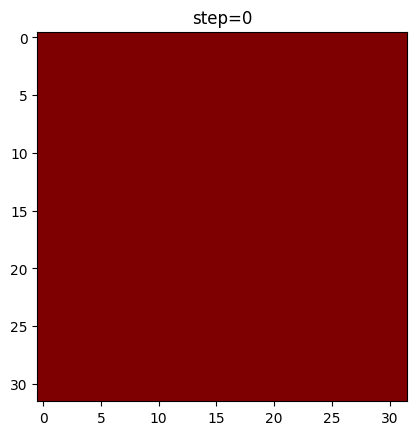

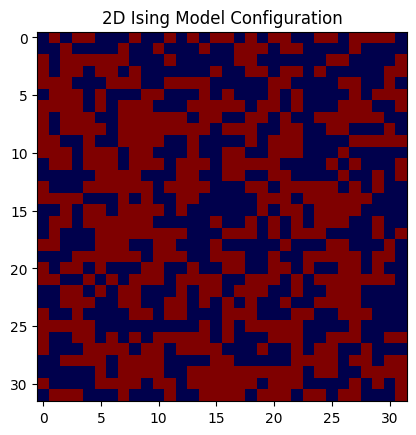

In [3]:
model = IsingModel2D(lattice_length=32,J=1,H=0)
simulation_data = model.run_monte_carlo_simulation(temperature=10,number_of_steps=1000,plot_every_nstep=1000)
model.plot_lattice();

In [4]:
data = {
    'temperatures':[],
    'energies':[],
    'magnetizations':[],
    'susceptibilities':[]
    }

model = IsingModel2D(lattice_length=32,J=1,H=0)
for T in np.arange(0.5,4.5,0.5):
    simulation_data = model.run_monte_carlo_simulation(temperature=T,
                                                       number_of_steps=2000,
                                                       data_to_collect=['average_energy','average_magnetization','total_magnetization'],
                                                       random=False, spin=1)
    data['temperatures'].append(T)
    data['energies'].append(simulation_data['average_energy'][-1])
    data['magnetizations'].append(simulation_data['average_magnetization'][-1])
    data['susceptibilities'].append(
        compute_susceptibility(
                            magnetizations=simulation_data['average_magnetization'][1000:],
                            temperature=T,N=model.lattice_length**2)
                            )

# Is the susceptibility calculated in the right way?

In [5]:
import pandas as pd

df = pd.DataFrame(data)
df

,temperatures,energies,magnetizations,susceptibilities
0,0.5,-2.000000,1.000000,0.000000
1,1.0,-2.000000,1.000000,0.001844
2,1.5,-1.953125,0.988281,0.026425
3,2.0,-1.707031,0.878906,0.404016
4,2.5,-1.210938,0.302734,6.298727
5,3.0,-0.917969,0.064453,1.460761
6,3.5,-0.628906,-0.070312,0.627899
7,4.0,-0.625000,0.007812,0.370390
